In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU, Bidirectional, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import pickle
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score




In [2]:
# Feature extraction using MFCC with delta and delta-delta features
def extract_features(file_path, sr=16000, n_mfcc=40):
    audio_data, _ = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    features = np.vstack((mfcc, delta_mfcc, delta2_mfcc))
    return np.mean(features.T, axis=0)  # Mean pooling

In [3]:
# Extract features for training and testing data
def load_data(file_paths):
    features = [extract_features(file) for file in file_paths]
    return np.array(features)

In [4]:
# Directories for audio files
train_real_directory = "E:/deepfake-audio-detection/temp/for-2seconds/training/real"
train_fake_directory = "E:/deepfake-audio-detection/temp/for-2seconds/training/fake"
validation_real_directory = "E:/deepfake-audio-detection/temp/for-2seconds/validation/real"
validation_fake_directory = "E:/deepfake-audio-detection/temp/for-2seconds/validation/fake"
test_real_directory = "E:/deepfake-audio-detection/temp/for-2seconds/testing/real"
test_fake_directory = "E:/deepfake-audio-detection/temp/for-2seconds/testing/fake"


In [5]:
# Get waveform (.wav) audio files
train_real_audio = [os.path.join(train_real_directory, file) for file in os.listdir(train_real_directory) if file.endswith('.wav')]
train_fake_audio = [os.path.join(train_fake_directory, file) for file in os.listdir(train_fake_directory) if file.endswith('.wav')]

validation_real_audio = [os.path.join(validation_real_directory, file) for file in os.listdir(validation_real_directory) if file.endswith('.wav')]
validation_fake_audio = [os.path.join(validation_fake_directory, file) for file in os.listdir(validation_fake_directory) if file.endswith('.wav')]

test_real_audio = [os.path.join(test_real_directory, file) for file in os.listdir(test_real_directory) if file.endswith('.wav')]
test_fake_audio = [os.path.join(test_fake_directory, file) for file in os.listdir(test_fake_directory) if file.endswith('.wav')]

In [8]:

# Prepare training data
train_files = train_real_audio + train_fake_audio
train_labels = [0] * len(train_real_audio) + [1] * len(train_fake_audio)

train_features = load_data(train_files)

In [ ]:
# Scale the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)



In [ ]:
# Prepare test data
test_files = [r'{}'.format(file) for file in test_real_audio + test_fake_audio]
test_labels = [0] * len(test_real_audio) + [1] * len(test_fake_audio)

test_features = load_data(test_files)
test_features = scaler.transform(test_features)

# Reshape features for RNN
train_features_rnn = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)
test_features_rnn = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)


In [ ]:
from keras.layers import BatchNormalization

# Model architecture (RNN) with Batch Normalization and more LSTM units
model_rnn = Sequential([
    LSTM(128, return_sequences=True, input_shape=(train_features_rnn.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(128),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


In [ ]:
# Train the RNN model
history_rnn = model_rnn.fit(train_features_rnn, np.array(train_labels), epochs=20, batch_size=32, validation_split=0.2)

# Save the RNN model weights
model_rnn.save_weights('rnn.h5')


Epoch 1/20
349/349 [==============================] - 229s 593ms/step - loss: 0.8763 - accuracy: 0.5843 - val_loss: 0.9266 - val_accuracy: 0.0476
Epoch 2/20
349/349 [==============================] - 187s 533ms/step - loss: 0.8161 - accuracy: 0.5883 - val_loss: 0.8587 - val_accuracy: 0.3736
Epoch 3/20
349/349 [==============================] - 176s 504ms/step - loss: 0.7800 - accuracy: 0.5950 - val_loss: 0.7605 - val_accuracy: 0.4656
Epoch 4/20
349/349 [==============================] - 175s 502ms/step - loss: 0.7500 - accuracy: 0.6066 - val_loss: 0.8383 - val_accuracy: 0.4427
Epoch 5/20
349/349 [==============================] - 183s 526ms/step - loss: 0.7168 - accuracy: 0.6207 - val_loss: 0.7541 - val_accuracy: 0.4918
Epoch 6/20
349/349 [==============================] - 180s 514ms/step - loss: 0.6934 - accuracy: 0.6279 - val_loss: 0.5842 - val_accuracy: 0.7228
Epoch 7/20
349/349 [==============================] - 179s 515ms/step - loss: 0.6646 - accuracy: 0.6426 - val_loss: 0.7877 -

In [ ]:

from keras.layers import Conv1D, MaxPooling1D, Flatten

# Reshape features for CNN
train_features_cnn = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)

# Model architecture (CNN)
model_cnn = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', input_shape=(train_features_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])



In [ ]:
# Train the CNN model
history_cnn = model_cnn.fit(train_features_cnn, np.array(train_labels), epochs=20, batch_size=32, validation_split=0.2)

# Save the CNN model weights
model_cnn.save_weights('cnn.h5')


Epoch 1/20
349/349 [==============================] - 62s 54ms/step - loss: 0.4010 - accuracy: 0.8133 - val_loss: 0.1721 - val_accuracy: 0.9420
Epoch 2/20
349/349 [==============================] - 18s 52ms/step - loss: 0.2311 - accuracy: 0.9069 - val_loss: 0.0915 - val_accuracy: 0.9756
Epoch 3/20
349/349 [==============================] - 19s 55ms/step - loss: 0.1787 - accuracy: 0.9292 - val_loss: 0.0907 - val_accuracy: 0.9660
Epoch 4/20
349/349 [==============================] - 20s 58ms/step - loss: 0.1437 - accuracy: 0.9445 - val_loss: 0.1019 - val_accuracy: 0.9670
Epoch 5/20
349/349 [==============================] - 20s 58ms/step - loss: 0.1298 - accuracy: 0.9506 - val_loss: 0.0707 - val_accuracy: 0.9760
Epoch 6/20
349/349 [==============================] - 21s 61ms/step - loss: 0.1121 - accuracy: 0.9563 - val_loss: 0.0843 - val_accuracy: 0.9710
Epoch 7/20
349/349 [==============================] - 20s 58ms/step - loss: 0.0959 - accuracy: 0.9643 - val_loss: 0.0501 - val_accuracy:

In [ ]:

# Model architecture (BiLSTM)
model_bilstm = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(train_features_rnn.shape[1], 1)),
    Dropout(0.3),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])


In [ ]:
# Ensure model_bilstm is defined
if 'model_bilstm' not in globals():
	model_bilstm = Sequential([
		Bidirectional(LSTM(128, return_sequences=True), input_shape=(train_features_rnn.shape[1], 1)),
		Dropout(0.3),
		Bidirectional(LSTM(128)),
		Dropout(0.3),
		Dense(1, activation='sigmoid')
	])


	model_bilstm.compile(optimizer=tf.keras.optimizers.Adam(),
						 loss='binary_crossentropy',
						 metrics=['accuracy'])

# Train the BiLSTM model
history_bilstm = model_bilstm.fit(train_features_rnn, np.array(train_labels), epochs=20, batch_size=32, validation_split=0.2)

# Save the BiLSTM model weights
model_bilstm.save_weights('bilstm.h5')

Epoch 1/20
349/349 [==============================] - 405s 1s/step - loss: 0.4602 - accuracy: 0.7577 - val_loss: 0.4332 - val_accuracy: 0.9158
Epoch 2/20
349/349 [==============================] - 340s 973ms/step - loss: 0.3077 - accuracy: 0.8649 - val_loss: 0.3147 - val_accuracy: 0.8850
Epoch 3/20
349/349 [==============================] - 349s 1s/step - loss: 0.2156 - accuracy: 0.9127 - val_loss: 0.1815 - val_accuracy: 0.9448
Epoch 4/20
349/349 [==============================] - 347s 994ms/step - loss: 0.1688 - accuracy: 0.9369 - val_loss: 0.1427 - val_accuracy: 0.9513
Epoch 5/20
349/349 [==============================] - 348s 999ms/step - loss: 0.1333 - accuracy: 0.9506 - val_loss: 0.0783 - val_accuracy: 0.9796
Epoch 6/20
349/349 [==============================] - 338s 969ms/step - loss: 0.1078 - accuracy: 0.9603 - val_loss: 0.1992 - val_accuracy: 0.9273
Epoch 7/20
349/349 [==============================] - 341s 976ms/step - loss: 0.0956 - accuracy: 0.9642 - val_loss: 0.0738 - val_a

In [ ]:
# Model architecture (GRU)
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(train_features_rnn.shape[1], 1)),
    Dropout(0.3),
    GRU(128),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_gru.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


In [ ]:


# Train the GRU model
history_gru = model_gru.fit(train_features_rnn, np.array(train_labels), epochs=20, batch_size=32, validation_split=0.2)

# Save the GRU model weights
model_gru.save_weights('gru.h5')


Epoch 1/20
349/349 [==============================] - 181s 351ms/step - loss: 0.6370 - accuracy: 0.6475 - val_loss: 0.6996 - val_accuracy: 0.5476
Epoch 2/20
349/349 [==============================] - 135s 388ms/step - loss: 0.5837 - accuracy: 0.6958 - val_loss: 0.8462 - val_accuracy: 0.4993
Epoch 3/20
349/349 [==============================] - 137s 392ms/step - loss: 0.6141 - accuracy: 0.6626 - val_loss: 0.7803 - val_accuracy: 0.3449
Epoch 4/20
349/349 [==============================] - 139s 397ms/step - loss: 0.6172 - accuracy: 0.6498 - val_loss: 1.1515 - val_accuracy: 0.2052
Epoch 5/20
349/349 [==============================] - 135s 387ms/step - loss: 0.5757 - accuracy: 0.6803 - val_loss: 0.8691 - val_accuracy: 0.4287
Epoch 6/20
349/349 [==============================] - 144s 412ms/step - loss: 0.5370 - accuracy: 0.7131 - val_loss: 0.6630 - val_accuracy: 0.6966
Epoch 7/20
349/349 [==============================] - 131s 375ms/step - loss: 0.4975 - accuracy: 0.7392 - val_loss: 0.5251 -

In [ ]:

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [ ]:
# Prepare test data
test_files = [r'{}'.format(file) for file in test_real_audio + test_fake_audio]
test_labels = [0] * len(test_real_audio) + [1] * len(test_fake_audio)

test_features = load_data(test_files)
test_features = scaler.transform(test_features)
test_features_rnn = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)
test_features_cnn = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)


In [ ]:
# Evaluate the RNN model
predictions_rnn = (model_rnn.predict(test_features_rnn) > 0.5).astype(int)

print("\nRNN Classification Report:")
print(classification_report(test_labels, predictions_rnn))


34/34 [==============================] - 30s 124ms/step

RNN Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.39      0.49       544
           1       0.57      0.81      0.67       544

    accuracy                           0.60      1088
   macro avg       0.62      0.60      0.58      1088
weighted avg       0.62      0.60      0.58      1088



In [ ]:
# Ensure predictions_rnn is defined
if 'predictions_rnn' not in globals():
	predictions_rnn = (model_rnn.predict(test_features_rnn) > 0.5).astype(int)

# Calculate accuracy for RNN
accuracy_rnn = accuracy_score(test_labels, predictions_rnn)
print(f"RNN Model Accuracy: {accuracy_rnn * 100:.2f}%")


RNN Model Accuracy: 60.11%


In [ ]:
# Evaluate the CNN model
predictions_cnn = (model_cnn.predict(test_features_cnn) > 0.5).astype(int)

print("\nCNN Classification Report:")
print(classification_report(test_labels, predictions_cnn))


34/34 [==============================] - 2s 10ms/step

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       544
           1       0.95      0.96      0.95       544

    accuracy                           0.95      1088
   macro avg       0.95      0.95      0.95      1088
weighted avg       0.95      0.95      0.95      1088



In [ ]:
# Calculate accuracy for CNN
accuracy_cnn = accuracy_score(test_labels, predictions_cnn)
print(f"CNN Model Accuracy: {accuracy_cnn * 100:.2f}%")


CNN Model Accuracy: 95.13%


In [ ]:
# Evaluate the BiLSTM model
predictions_bilstm = (model_bilstm.predict(test_features_rnn) > 0.5).astype(int)

print("\nBiLSTM Classification Report:")
print(classification_report(test_labels, predictions_bilstm))


34/34 [==============================] - 12s 186ms/step

BiLSTM Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       544
           1       1.00      0.85      0.92       544

    accuracy                           0.92      1088
   macro avg       0.93      0.92      0.92      1088
weighted avg       0.93      0.92      0.92      1088



In [ ]:
# Calculate accuracy for BiLSTM
accuracy_bilstm = accuracy_score(test_labels, predictions_bilstm)
print(f"BiLSTM Model Accuracy: {accuracy_bilstm * 100:.2f}%")


BiLSTM Model Accuracy: 92.28%


In [ ]:
# Evaluate the GRU model
predictions_gru = (model_gru.predict(test_features_rnn) > 0.5).astype(int)

print("\nGRU Classification Report:")
print(classification_report(test_labels, predictions_gru))


34/34 [==============================] - 5s 76ms/step

GRU Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       544
           1       0.92      0.66      0.77       544

    accuracy                           0.80      1088
   macro avg       0.83      0.80      0.80      1088
weighted avg       0.83      0.80      0.80      1088



In [ ]:
# Calculate accuracy for GRU
accuracy_gru = accuracy_score(test_labels, predictions_gru)
print(f"GRU Model Accuracy: {accuracy_gru * 100:.2f}%")


GRU Model Accuracy: 80.33%


In [ ]:
# XGBoost model
model_xgb = xgb.XGBClassifier()


In [ ]:
param_grid = {
    'n_estimators': [200, 300],  
    'max_depth': [5, 7],  
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],  
    'colsample_bytree': [0.7, 0.8],  
    'gamma': [0, 0.1],  
    'min_child_weight': [1, 3 ],
    'tree_method': ['hist']  
}
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(train_features, train_labels)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")


Fitting 3 folds for each of 128 candidates, totalling 384 fits


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8, 'tree_method': 'hist'}
Best cross-validation accuracy: 0.9909716251074806


In [ ]:
# Train the XGBoost model with the best parameters
model_xgb = xgb.XGBClassifier(**grid_search.best_params_)
model_xgb.fit(train_features, train_labels)


 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:

# Save the XGBoost model
model_xgb.save_model('model_xgb.json')

In [ ]:
# Evaluate the XGBoost model
predictions_xgb = model_xgb.predict(test_features)

print("\nXGBoost Classification Report:")
print(classification_report(test_labels, predictions_xgb))



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.97      0.75       544
           1       0.93      0.38      0.54       544

    accuracy                           0.68      1088
   macro avg       0.77      0.68      0.65      1088
weighted avg       0.77      0.68      0.65      1088



In [ ]:
# Calculate accuracy for XGBoost
accuracy_xgb = accuracy_score(test_labels, predictions_xgb)
print(f"XGBoost Model Accuracy: {accuracy_xgb * 100:.2f}%")


XGBoost Model Accuracy: 67.65%


In [ ]:

combined_predictions = (predictions_rnn*0.35 + predictions_cnn+ predictions_bilstm + predictions_gru*0.35 + predictions_xgb*0.5)

In [ ]:
# Ensure predictions are in the same format
predictions_rnn = predictions_rnn.flatten()
predictions_cnn = predictions_cnn.flatten()
predictions_bilstm = predictions_bilstm.flatten()
predictions_gru = predictions_gru.flatten()
predictions_xgb = predictions_xgb.flatten()


In [ ]:


# Ensure test_labels is a binary array
test_labels_binary = np.array(test_labels).astype(int)

# Combine predictions using majority voting
combined_predictions_binary = (combined_predictions > 0.5).astype(int)

# Ensure combined_predictions_binary is flattened and matches the length of test_labels_binary
combined_predictions_binary = combined_predictions_binary.flatten()[:len(test_labels_binary)]

# Calculate overall accuracy
overall_accuracy = accuracy_score(test_labels_binary, combined_predictions_binary)
print(f"Overall Accuracy of All Models: {overall_accuracy * 100:.2f}%")





Overall Accuracy of All Models: 67.65%


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Step 1: Generate weighted predictions from base models
def get_weighted_predictions(models, features_rnn, features_cnn, features_scaled, weights):
    predictions = []
    for model_name, model in models.items():
        if model_name in ['rnn', 'bilstm', 'gru']:
            pred = model.predict(features_rnn).flatten() * weights[model_name]
        elif model_name == 'cnn':
            pred = model.predict(features_cnn).flatten() * weights[model_name]
        elif model_name == 'xgb':
    
            
            pred = model.predict(features_scaled) * weights[model_name]
        predictions.append(pred)
    return np.sum(predictions, axis=0)  
# Base models
models = {
    'rnn': model_rnn,
    'cnn': model_cnn,
    'bilstm': model_bilstm,
    'gru': model_gru,
    'xgb': model_xgb
}
# Define weights for each model
weights = {
    'rnn': 0.35,
    'cnn': 1.0,  
    'bilstm': 1.0,  
    'gru': 0.35,
    'xgb': 0.5
}
# Step 2: Generate weighted predictions for training data
train_weighted_predictions = get_weighted_predictions(models, train_features_rnn, train_features_cnn, train_features, weights)

# Step 3: Train a meta-model
meta_model = LogisticRegression()  
meta_model.fit(train_weighted_predictions.reshape(-1, 1), train_labels)

# Save the meta-model coefficients and intercept
np.save("meta_model_coef.npy", meta_model.coef_)
np.save("meta_model_intercept.npy", meta_model.intercept_)


# Step 4: Generate weighted predictions for the test set
test_weighted_predictions = get_weighted_predictions(models, test_features_rnn, test_features_cnn, test_features, weights)

# Step 5: Use the meta-model to make final predictions
final_predictions = meta_model.predict(test_weighted_predictions.reshape(-1, 1))

# Step 6: Evaluate the stacking model
print("\nStacking Model Classification Report:")
print(classification_report(test_labels, final_predictions))
stacking_accuracy = accuracy_score(test_labels, final_predictions)
print(f"Stacking Model Accuracy: {stacking_accuracy * 100:.2f}%")

34/34 [==============================] - 4s 113ms/step

Stacking Model Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       544
           1       0.99      0.89      0.94       544

    accuracy                           0.94      1088
   macro avg       0.94      0.94      0.94      1088
weighted avg       0.94      0.94      0.94      1088

Stacking Model Accuracy: 94.03%


34/34 [==============================] - 44s 482ms/step


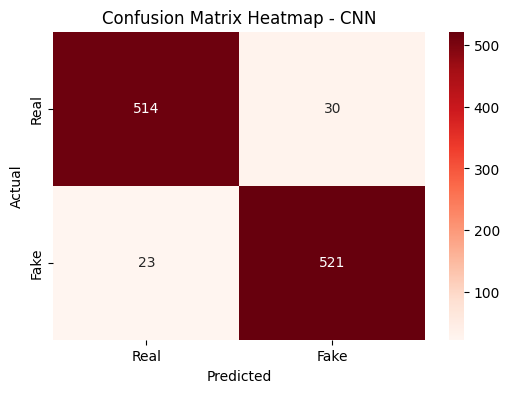

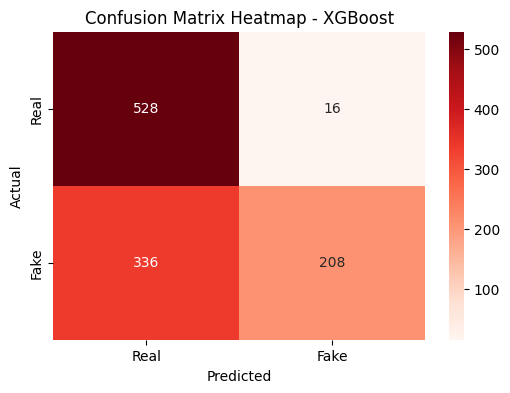

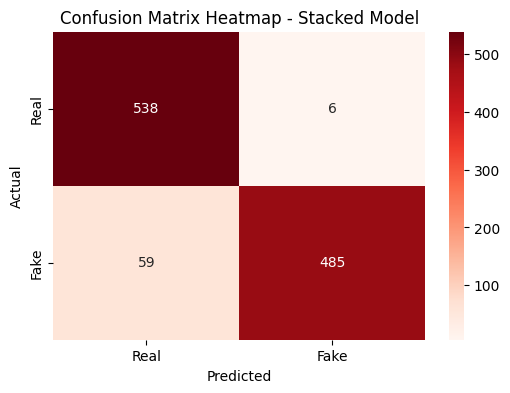

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot heatmap for confusion matrix
def plot_confusion_matrix_heatmap(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.title(f"Confusion Matrix Heatmap - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# CNN Model
predictions_cnn = (model_cnn.predict(test_features_cnn) > 0.5).astype(int).flatten()
plot_confusion_matrix_heatmap("CNN", test_labels, predictions_cnn)

# XGBoost Model
predictions_xgb = (model_xgb.predict(test_features) > 0.5).astype(int).flatten()
plot_confusion_matrix_heatmap("XGBoost", test_labels, predictions_xgb)

# Stacked Model
plot_confusion_matrix_heatmap("Stacked Model", test_labels, final_predictions)

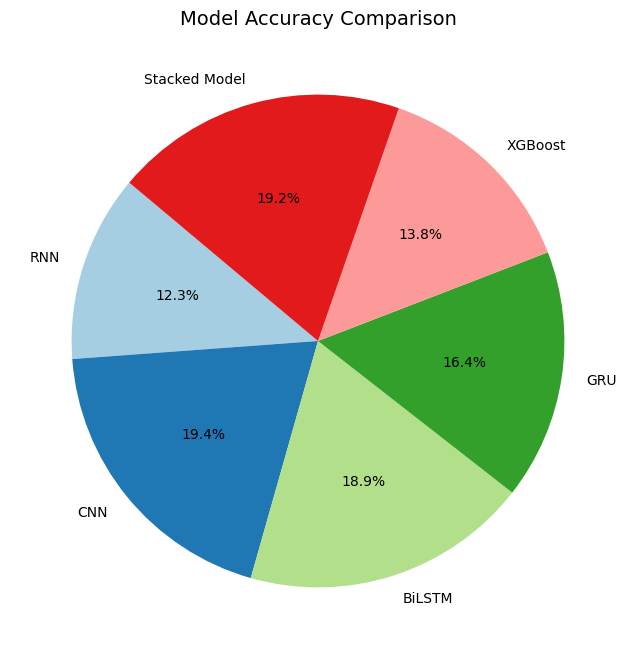

In [ ]:
import matplotlib.pyplot as plt

# Model names and their accuracies
models = ["RNN", "CNN", "BiLSTM", "GRU", "XGBoost", "Stacked Model"]
accuracies = [60.11, 95.13, 92.28, 80.33, 67.65, 94.03]

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(accuracies, labels=models, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.show()

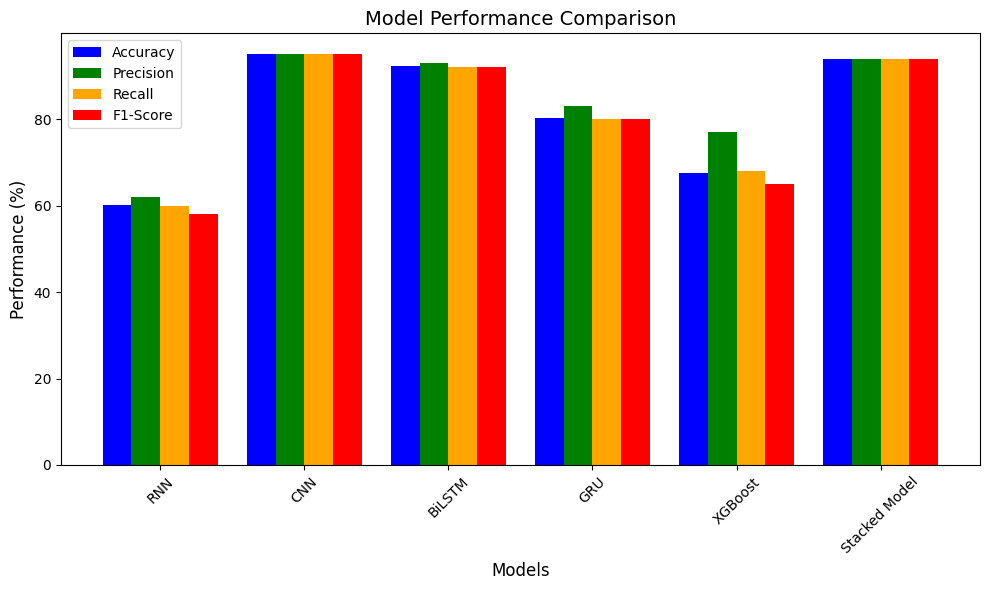

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model performance metrics
models = ["RNN", "CNN", "BiLSTM", "GRU", "XGBoost", "Stacked Model"]
accuracy = [60.11, 95.13, 92.28, 80.33, 67.65, 94.03]
precision = [62, 95, 93, 83, 77, 94]
recall = [60, 95, 92, 80, 68, 94]
f1_score = [58, 95, 92, 80, 65, 94]

# Bar width
bar_width = 0.2

# X-axis positions for each group of bars
x = np.arange(len(models))

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, accuracy, width=bar_width, label="Accuracy", color="blue")
plt.bar(x, precision, width=bar_width, label="Precision", color="green")
plt.bar(x + bar_width, recall, width=bar_width, label="Recall", color="orange")
plt.bar(x + 2 * bar_width, f1_score, width=bar_width, label="F1-Score", color="red")

# Adding labels and title
plt.xlabel("Models", fontsize=12)
plt.ylabel("Performance (%)", fontsize=12)
plt.title("Model Performance Comparison", fontsize=14)
plt.xticks(x + bar_width / 2, models, rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

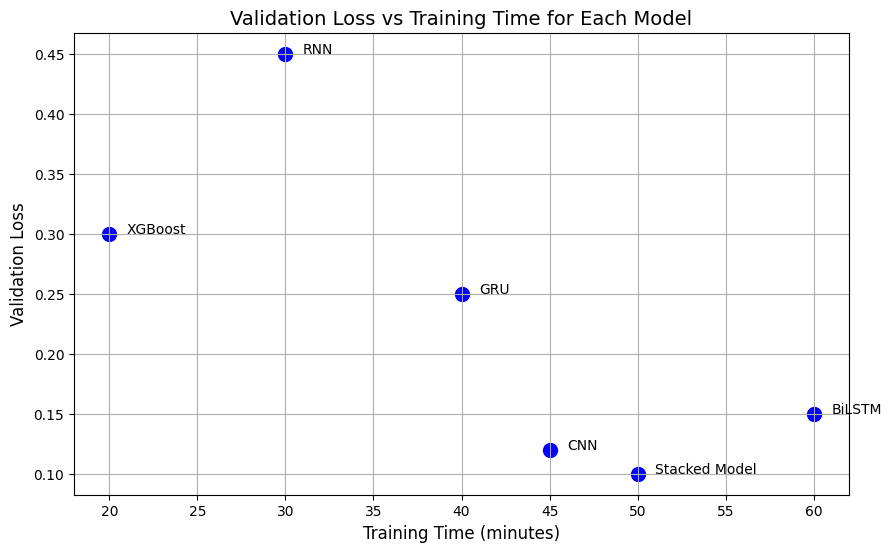

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ["RNN", "CNN", "BiLSTM", "GRU", "XGBoost", "Stacked Model"]

# Validation loss and training time for each model (example values)
validation_loss = [0.45, 0.12, 0.15, 0.25, 0.30, 0.10]  # Replace with actual values
training_time = [30, 45, 60, 40, 20, 50]  # Replace with actual values (in minutes)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(training_time, validation_loss, color='blue', s=100)

# Annotate each point with the model name
for i, model in enumerate(models):
    plt.text(training_time[i] + 1, validation_loss[i], model, fontsize=10)

# Adding labels and title
plt.xlabel("Training Time (minutes)", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.title("Validation Loss vs Training Time for Each Model", fontsize=14)
plt.grid(True)
plt.show()